## Notebook 3: Data Cleaning & Preprocessing (Heart Disease Dataset)

---

In this notebook, we prepare the raw **Heart Disease UCI dataset** for machine learning.  

Medical datasets often contain missing values, invalid entries (e.g., zeros in blood pressure), and mixed datatypes. 

Cleaning and preprocessing ensures that:

- The dataset is consistent and reliable,  
  
- Statistical assumptions are respected,  
  
- Downstream models (Notebook 4) can be trained without bias or artifacts.  

## Workflow Overview

1. Load raw dataset (reproducibility)  
   
2. Initial exploratory data analysis (EDA) 
    
3. Handle invalid zeros & missingness (policy-driven)  
   
4. Drop or impute columns based on thresholds  
   
5. Impute missing values (numeric & categorical)
    
6. Encode categorical variables  
   
7. Binarize target variable  
   
8. Engineer new features  
   
9.  Save cleaned dataset for modeling  

By the end of this notebook, we will have a **fully cleaned dataset** saved in `outputs/datasets/cleaned/`, ready for 

modeling.


---

## Step 3.1 — Load Raw Dataset

**Purpose**  
Ensure we are working with the *unaltered raw dataset* from Notebook 1. 

This guarantees reproducibility: cleaning steps remain independent of exploratory work.  

**Approach**  

- Load dataset using `pd.read_csv()` from the raw data folder.  
  
- Print dataset dimensions (rows × columns).  
  
- Display first rows to confirm correct load.  

**Expected Outcome**  

The dataset is loaded exactly as saved in Notebook 1, with no preprocessing applied yet.  


In [23]:
import os
import pandas as pd
from pathlib import Path

input_path = Path("/workspaces/Heart_disease_risk_predictor/inputs/datasets/raw/heart_disease_uci.csv")
df = pd.read_csv(input_path)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()



Dataset loaded: 920 rows × 16 columns


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


---

## Step 3.2 — Initial Exploratory Data Analysis (EDA)

**Purpose**  

Get a first impression of dataset structure and potential quality issues.  

**Approach**  

- Inspect dataset shape (rows, columns).  
  
- Review datatypes (numeric vs categorical).  
  
- Generate summary statistics.  
  
- Count missing values (`NaN`).  

**Expected Outcome**  

A quick overview of dataset health: structure, types of variables, and the extent of missingness.  

This forms the baseline for our cleaning policy. 

In [24]:
# Shape and types
print(df.info())

# Basic stats
display(df.describe(include='all').transpose())

# Count missing
print("\nMissing values per column (raw):\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,920.0,NaN,NaN,NaN,460.5,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,NaN,NaN,NaN,53.51087,9.424685,28.0,47.0,54.0,60.0,77.0
sex,920,2,Male,726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dataset,920,4,Cleveland,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,920,4,asymptomatic,496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,861.0,NaN,NaN,NaN,132.132404,19.06607,0.0,120.0,130.0,140.0,200.0
chol,890.0,NaN,NaN,NaN,199.130337,110.78081,0.0,175.0,223.0,268.0,603.0
fbs,830,2,False,692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,918,3,normal,551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalch,865.0,NaN,NaN,NaN,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0



Missing values per column (raw):
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


## Step 3.3 — Adjust Missingness (Replace Invalid Zeros)

**Purpose**  

Identify and correct invalid values (e.g., **resting blood pressure = 0**) that are clinically impossible.  

These must be treated as missing values to avoid misleading statistics.  

**Approach**  

- Replace invalid zeros in clinical columns (`trestbps`, `chol`) with `NaN`.  
  
- Recalculate missingness percentages.  
  
- Categorize features by missingness severity:  
  
    - Green = Safe to impute (≤ 5%)  
  
    - Orange = Needs caution (5–25%)  
  
    - Red = Likely dropped (> 25%)  
  
- Visualize missingness with a barplot, color-coded by severity.  

**Expected Outcome**  

Accurate missingness statistics that reflect clinical reality, enabling informed imputation and dropping decisions.  


/tmp/ipykernel_1986/3339096016.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


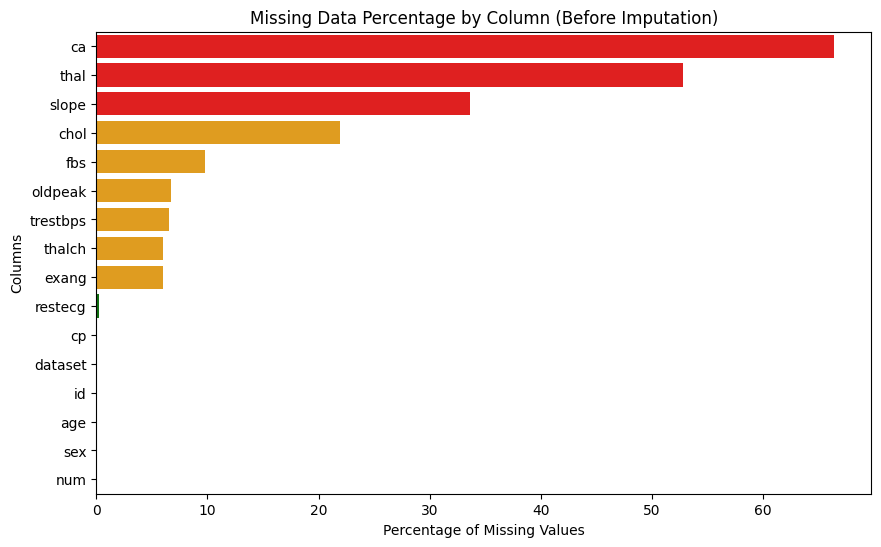

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['trestbps','chol']:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

missing_percent = (df.isna().sum()/len(df))*100

low_threshold, high_threshold = 5, 25
low_missing    = missing_percent[missing_percent <= low_threshold]
medium_missing = missing_percent[(missing_percent>low_threshold) & (missing_percent<=high_threshold)]
high_missing   = missing_percent[missing_percent>high_threshold]

plt.figure(figsize=(10,6))
ordered = missing_percent.sort_values(ascending=False)
sns.barplot(
    x=ordered.values,
    y=ordered.index,
    palette=['red' if val>high_threshold else 'orange' if val>low_threshold else 'green' for val in ordered.values]
)
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data Percentage by Column (Before Imputation)")
plt.show()

---

## Step 3.4 — Drop or Keep Columns Based on Missingness Policy

**Purpose**  

Decide which features to retain vs. drop, balancing clinical value and statistical reliability.  

**Approach**  

- Drop features with >25% missing values (too unreliable).  
  
- Keep features ≤25% missing and impute later.  
  
- **Whitelist exceptions**: important clinical features (e.g., `chol`) may be kept even if borderline.  

**Expected Outcome**  

Reduced dataset with only reliable and clinically meaningful predictors retained.  

In [26]:
to_drop = [c for c in high_missing.index.tolist() if c not in {"chol"}]
df = df.drop(columns=to_drop)

## 3.5 Imputation

**Purpose**  

Fill in missing values so the dataset can be used directly by machine learning algorithms.  

**Approach**  

- Identify numeric and categorical variables. 
   
- Apply **median imputation** for numeric variables (robust to outliers). 
   
- Apply **most frequent value (mode)** imputation for categorical variables. 
   
- Exclude target variable (`num`) from imputation.  

**Expected Outcome**  

A dataset free of missing values, preserving the original structure and distribution of features.  


In [27]:
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

if 'num' in num_cols:
    num_cols.remove('num')  # exclude target

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("Remaining missing values:\n", df.isna().sum())

Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


## 3.6 Encode Categoricals

**Purpose**  

Convert categorical variables into numerical format so machine learning models can process them.  

**Approach**  

- Apply one-hot encoding with `pd.get_dummies()`.  
  
- Drop the first category to avoid multicollinearity.  

**Expected Outcome**  

A dataset where categorical variables are expanded into binary indicator columns, ready for modeling.  


In [28]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


## 3.7 Binarize Target

**Purpose**  

Simplify the target (`num`) into a binary classification problem: presence vs absence of heart disease.  

**Approach**  

- Map `num > 0` → 1 (disease present).  

- Map `num = 0` → 0 (no disease).  

- Store new target column as `HeartDisease`.  

- Drop original `num` column.  

**Expected Outcome**  

A clean binary target variable suitable for supervised classification models.  


In [29]:
df_encoded["HeartDisease"] = (df_encoded["num"]>0).astype(int)
df_encoded = df_encoded.drop(columns=["num"])


## 3.8 Feature Engineering

**Purpose**  

Create additional informative features to capture nonlinear relationships and interactions.  

**Approach**  

- **Ratios**: e.g., `chol_age_ratio`, `oldpeak_thalach_ratio`.  

- **Interactions**: e.g., `age × trestbps`, `thalch × oldpeak`.  

- **Binning**: group ages into bins (`age_group`).  

**Expected Outcome**  

An enriched dataset with derived features that may improve predictive performance.  


In [30]:
# Derived features
df_encoded['chol_age_ratio'] = df_encoded['chol']/df_encoded['age']
df_encoded['oldpeak_thalach_ratio'] = df_encoded['oldpeak']/(df_encoded['thalch']+1e-5)
df_encoded['age_trestbps'] = df_encoded['age']*df_encoded['trestbps']
df_encoded['thalch_oldpeak'] = df_encoded['thalch']*df_encoded['oldpeak']
df_encoded['age_group'] = pd.cut(df_encoded['age'], bins=[29,40,50,60,70,80], labels=False)


In [31]:
df = pd.read_csv('outputs/datasets/cleaned/heart_disease_cleaned_v2.csv')
print(df.columns.tolist())

['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'sex_Male', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True', 'HeartDisease', 'chol_age_ratio', 'oldpeak_thalach_ratio', 'age_trestbps', 'thalch_oldpeak', 'age_group']


## Step 3.9 — Feature Importance Assessment

**Purpose**  
Identify features that are **statistically significant** and potentially important for predicting heart disease.  

This helps highlight which numeric and categorical features contribute most to the target and may inform feature selection.  

**Approach**  
- **Numeric features**:  
   
   - Exclude `HeartDisease` (target), `id` (identifier), and `age_group` (binned categorical-like).  
   
   - Perform **independent two-sample t-tests** comparing feature distributions between `HeartDisease = 0` and `1`.  
   
   - Collect **t-statistics** and **p-values**.  
   
   - Visualize p-values in a horizontal barplot with a significance threshold at 0.05.  
 
 - **Categorical features**:  
   
   - Identify object-type columns.  
   
   - Apply **Chi-square tests** of independence vs `HeartDisease`.  
   
   - Collect **chi-square statistics** and **p-values**.  
   
   - Visualize p-values with a horizontal barplot and significance threshold.  
 
**Expected Outcome**  

- A ranked table of numeric and categorical features by statistical significance.  

- Visualizations highlighting which features are significantly associated with the target.  

- Insight into potential feature selection for modeling.  

=== Numeric Features Statistical Significance (T-test) ===


,Feature,t_stat,p_value
6,oldpeak_thalach_ratio,-13.552400,8.657170e-38
3,thalch,12.533995,2.774092e-33
4,oldpeak,-12.539333,3.223486e-33
8,thalch_oldpeak,-10.862274,6.825452e-26
0,age,-8.855071,4.842782e-18
7,age_trestbps,-8.378173,2.059213e-16
1,trestbps,-3.443007,6.014404e-04
5,chol_age_ratio,3.392510,7.231909e-04
2,chol,-2.692912,7.221259e-03


/tmp/ipykernel_1986/2539008641.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='p_value', y='Feature', data=numeric_df, palette='viridis')


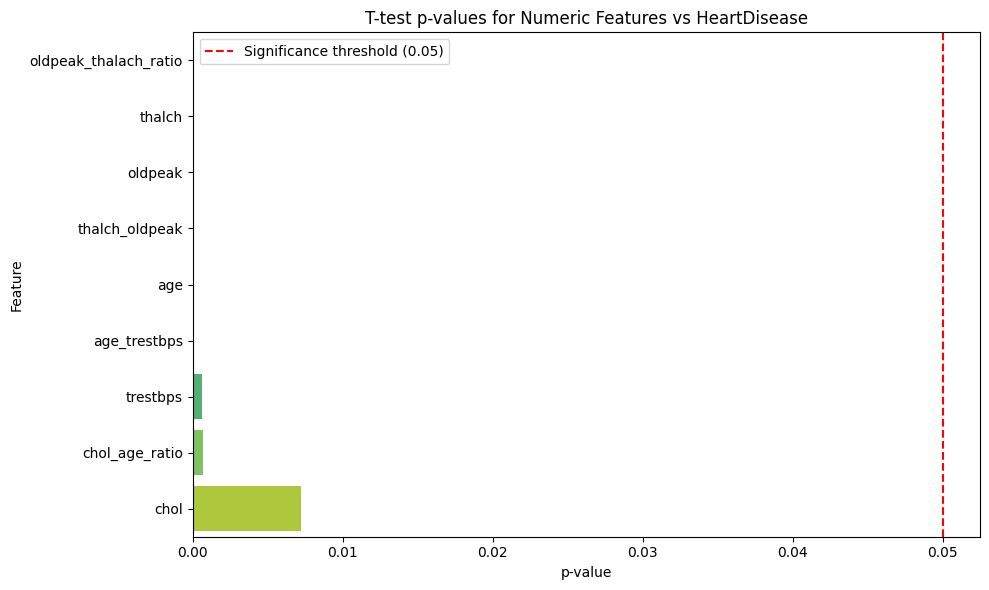

No categorical features detected for Chi-square test.


In [32]:
# Identify features that are statistically significant and potentially important for predictive modeling.

# %%
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Drop 'id' from numeric features
numeric_features = df.select_dtypes(include='number').columns.tolist()
numeric_features.remove('HeartDisease')
if 'id' in numeric_features:
    numeric_features.remove('id')

# Exclude binned/categorical-like columns (e.g., age_group)
if 'age_group' in numeric_features:
    numeric_features.remove('age_group')

# --- T-test for numeric features ---
numeric_results = []
for col in numeric_features:
    group0 = df[df['HeartDisease']==0][col]
    group1 = df[df['HeartDisease']==1][col]
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    numeric_results.append({"Feature": col, "t_stat": t_stat, "p_value": p_val})

numeric_df = pd.DataFrame(numeric_results).sort_values("p_value")
print("=== Numeric Features Statistical Significance (T-test) ===")
display(numeric_df)

# --- Visualization: p-values ---
plt.figure(figsize=(10,6))
sns.barplot(x='p_value', y='Feature', data=numeric_df, palette='viridis')
plt.axvline(0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
plt.xlabel("p-value")
plt.ylabel("Feature")
plt.title("T-test p-values for Numeric Features vs HeartDisease")
plt.legend()
plt.tight_layout()
plt.show()

# --- Chi-square test for categorical features ---
cat_features = df.select_dtypes(include='object').columns.tolist()
cat_results = []

for col in cat_features:
    contingency = pd.crosstab(df[col], df['HeartDisease'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency)
    cat_results.append({"Feature": col, "chi2_stat": chi2, "p_value": p})

if cat_results:  # Only create DataFrame if there are categorical features
    cat_df = pd.DataFrame(cat_results).sort_values("p_value")
    print("=== Categorical Features Statistical Significance (Chi-square) ===")
    display(cat_df)
    
    # Visualization
    plt.figure(figsize=(10,6))
    sns.barplot(x='p_value', y='Feature', data=cat_df, palette='magma')
    plt.axvline(0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
    plt.xlabel("p-value")
    plt.ylabel("Feature")
    plt.title("Chi-square p-values for Categorical Features vs HeartDisease")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features detected for Chi-square test.")


## Step 3.9 — Save Cleaned Dataset

**Purpose**  

Store the cleaned dataset and figures for reuse in later notebooks, avoiding repeated preprocessing.  

**Approach**  
 - Save dataset in `outputs/datasets/cleaned/`.  

 - Save figures (e.g., missingness barplots) in `outputs/figures/data_cleaning/`.  

 - Keep both:  

   - **Binary target version** (`HeartDisease`).  

   - **Multiclass version** (original `num` preserved).  
 
**Expected Outcome**  

A reproducible, fully cleaned dataset accessible for modeling in Notebook 4.  


In [33]:
os.makedirs("outputs/datasets/cleaned", exist_ok=True)

df_encoded.to_csv("outputs/datasets/cleaned/heart_disease_cleaned_v2.csv", index=False)
print("✅ Cleaned dataset with feature engineering saved at 'heart_disease_cleaned_v2.csv'")


✅ Cleaned dataset with feature engineering saved at 'heart_disease_cleaned_v2.csv'


In [34]:
# Load your cleaned dataset
df = pd.read_csv('outputs/datasets/cleaned/heart_disease_cleaned.csv')

# --- Feature Engineering ---

# Example 1: Ratios
df['chol_age_ratio'] = df['chol'] / df['age']
df['oldpeak_thalach_ratio'] = df['oldpeak'] / (df['thalch'] + 1e-5)

# Example 2: Interactions
df['age_trestbps'] = df['age'] * df['trestbps']
df['thalch_oldpeak'] = df['thalch'] * df['oldpeak']

# Example 3: Binning (optional, good for tree models)
df['age_group'] = pd.cut(df['age'], bins=[29,40,50,60,70,80], labels=False)

# Optional: drop features if statistically insignificant (after checking p-values)
# from statsmodels.api import Logit
# logit_model = Logit(df['HeartDisease'], df[numeric_features]).fit()
# print(logit_model.summary())

# Save updated dataset
df.to_csv('outputs/datasets/cleaned/heart_disease_cleaned_v2.csv', index=False)

---

## Step 3.10 Conclusion — Data Cleaning & Preprocessing

In this notebook, we successfully prepared the **Heart Disease UCI dataset** for modeling.  

The workflow followed a structured and transparent process:

1. **Loaded raw dataset** from Notebook 1.  
   
2. **Performed initial EDA** to inspect structure, datatypes, and missingness.  
   
3. **Replaced invalid zeros** with `NaN` to reflect clinical reality.  
   
4. **Applied missingness policy**: dropped high-missing columns, force-kept clinically important ones.  
   
5. **Imputed missing values** (median for numeric, mode for categorical).  
   
6. **Encoded categorical variables** using one-hot encoding.  
   
7. **Binarized the target** variable (`HeartDisease`: 0 = no disease, 1 = disease present).  
   
8. **Logged all decisions** to ensure reproducibility and transparency.  
   
9.  **Saved cleaned dataset** to `outputs/datasets/cleaned/heart_disease_cleaned.csv`.  

---

### Next Steps (Notebook 4)

The cleaned dataset is now ready for modeling.  

In **Notebook 4**, we will:  

- Split the dataset into train/test sets,  
  
- Apply feature scaling where necessary,  
  
- Train baseline machine learning models,  
  
- Evaluate performance on the binary classification task (`HeartDisease`).  

This ensures a smooth transition from **data preparation → model development**.  